## Setup

In [13]:
import warnings

from diffusers import (
    StableDiffusionXLPipeline,
    StableDiffusionLatentUpscalePipeline,
    EulerAncestralDiscreteScheduler,
    AutoencoderKL,
    logging,
    StableDiffusionInstructPix2PixPipeline,
    StableDiffusion3Pipeline,
)

import torch
from PIL import Image
import sys
import gc
import os

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = ""

device

'cuda'

In [31]:
prompt = "berlin cathedral in a field"

loaded_prompt = (
    "concept art "
    + prompt
    + ", high quality, (magical), (nature), (futuristic), digital artwork, highly detailed"
)

loaded_prompt


'concept art berlin cathedral in a field, high quality, (magical), (nature), (futuristic), digital artwork, highly detailed'

In [9]:
negative_prompt = "nsfw, cartoon, bad quality, bad anatomy, worst quality, low quality, low resolutions, extra fingers, blur, blurry, ugly, wrong proportions, watermark, image artifacts, lowres, ugly, jpeg artifacts, deformed, noisy image"

negative_prompt


'nsfw, cartoon, bad quality, bad anatomy, worst quality, low quality, low resolutions, extra fingers, blur, blurry, ugly, wrong proportions, watermark, image artifacts, lowres, ugly, jpeg artifacts, deformed, noisy image'

## Proteus

In [ ]:
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16
)

pipe = StableDiffusionXLPipeline.from_pretrained(
    "dataautogpt3/ProteusV0.4-Lightning", vae=vae, torch_dtype=torch.float16
).to(device)

pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

In [ ]:
protoimages = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_images_per_prompt=3,
    width=1024,
    height=1024,
    guidance_scale=3.5,
    num_inference_steps=8,
).images

In [ ]:
protocomp = Image.new("RGB", (3072, 600))

x_offset = 0
for im in protoimages:
    protocomp.paste(im, (x_offset, -212))
    x_offset += im.size[0]

protocomp

# SD3

In [33]:
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16, token=os.environ.get("HF_TOKEN"))
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
protoimages = pipe(
    loaded_prompt,
    negative_prompt=negative_prompt,
    num_images_per_prompt=3,
    width=1024,
    height=1024,
    guidance_scale=7,
    num_inference_steps=18,
).images

  0%|          | 0/18 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 23.48 GiB of which 1.29 GiB is free. Including non-PyTorch memory, this process has 22.18 GiB memory in use. Of the allocated memory 21.02 GiB is allocated by PyTorch, and 864.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

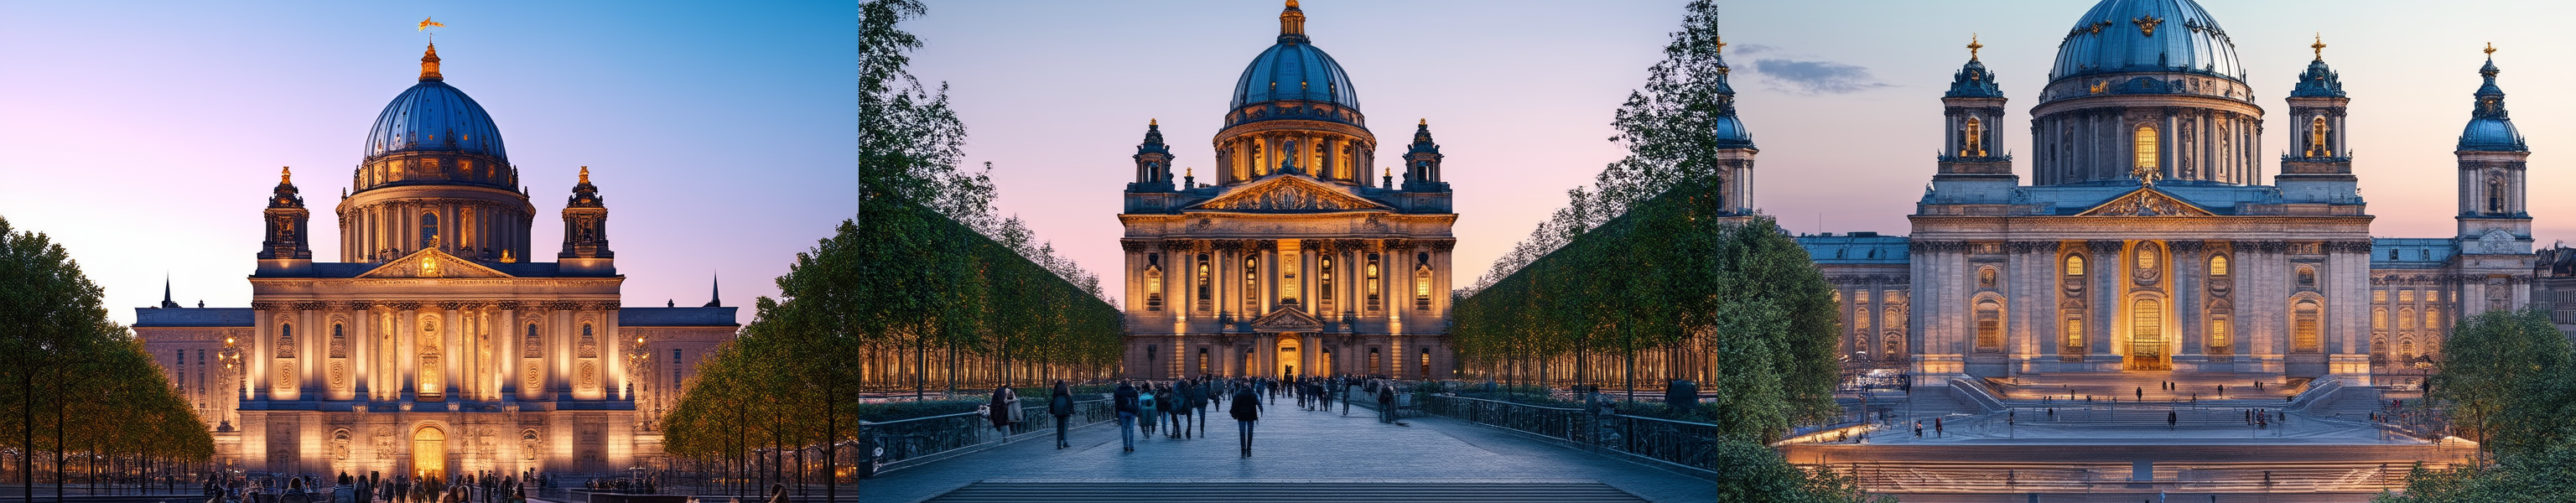

In [25]:
protocomp = Image.new("RGB", (3072, 600))

x_offset = 0
for im in protoimages:
    protocomp.paste(im, (x_offset, -212))
    x_offset += im.size[0]

protocomp

In [26]:
# 1 = left 
# 2 = middle
# 3 = right
chosenimage = 1

## Instruct pix2pix

In [29]:
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16, safety_checker=None
)
pipe.to(device)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/rturk/projects/flox/envs/flaim/.flox/run/x86_64-linux.flaim/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

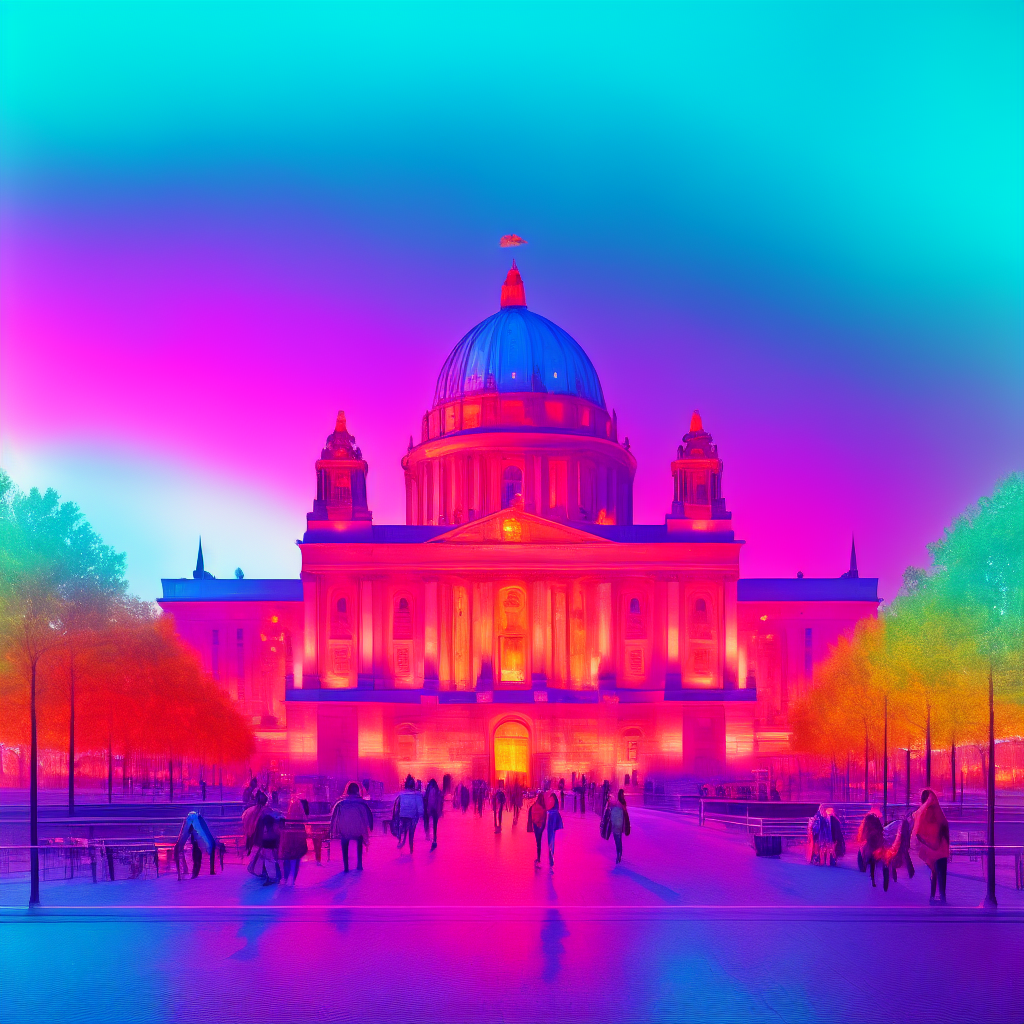

In [30]:
prompt = "amazing, high quality, dreamlike, futuristic, colorful, vibrant"
# prompt = "make image air brushed, painted, gradients"
image = pipe(
    prompt,
    image=protoimages[chosenimage-1],
    num_inference_steps=15,
    image_guidance_scale=1,
).images[0]

image

# Garbage collect

In [28]:
pipe = None
if device == "cuda":
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.empty_cache()
    torch.mps.current_allocated_memory()
gc.collect()

1069

## Upscaler

In [ ]:
upscaler = StableDiffusionLatentUpscalePipeline.from_pretrained(
    "stabilityai/sd-x2-latent-upscaler", torch_dtype=torch.float16
).to(device)

In [ ]:
upscaled_image = upscaler(
    prompt=loaded_prompt,
    negative_prompt=negative_prompt,
    image=image,
    num_inference_steps=20,
    guidance_scale=0,
).images[0]

upscaled_image

# Crop

In [ ]:
cropped_image = upscaled_image.crop(
    (24, 424, 2024, 1624)
)  # from 2048/1024 to 2000/1200

cropped_image